# Generating digits using Autoencoders

This notebook documents my attempt at generating new images using an autoencoder. The autoencoder is trained on MNIST dataset.

# Overview of the sections:
- **Regenerate dataset:** In this section, I use a simple autoencoder to regenerate images from the MNIST dataset.
- **Improve autoencoder:** Then, I spice up the model architecture to get the best validation loss
- **Generate new RBG Images:** Finally using the autoencoder, I created a function that takes in a digit and outputs RBG image of the digit.

# Setup

In [1]:
! pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
! pip install gdown

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
# DO NOT MODIFY
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import time
from numpy.typing import NDArray
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()


In [3]:
# DO NOT MODIFY
import gdown

os.makedirs("data", exist_ok=True)

mnist_train_file_id = "1JMd32keTqqUAofWRPBnIg9PpusJD8mYt"
mnist_train_output = "data/mnist_dataset_train.pt"  # Desired filename for the downloaded file

mnist_test_file_id = "1OG8mBivCdXBwH8uCMvjWnVhHFtRagmSU"
mnist_test_output = "data/mnist_dataset_test.pt"  # Desired filename for the downloaded file

# Download the file
gdown.download(f"https://drive.google.com/uc?id={mnist_train_file_id}", mnist_train_output, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={mnist_test_file_id}", mnist_test_output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1JMd32keTqqUAofWRPBnIg9PpusJD8mYt
From (redirected): https://drive.google.com/uc?id=1JMd32keTqqUAofWRPBnIg9PpusJD8mYt&confirm=t&uuid=4664ac2e-3866-473c-b82f-3381b17625c4
To: /content/data/mnist_dataset_train.pt
100%|██████████| 47.5M/47.5M [00:00<00:00, 81.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8mBivCdXBwH8uCMvjWnVhHFtRagmSU
To: /content/data/mnist_dataset_test.pt
100%|██████████| 7.92M/7.92M [00:00<00:00, 52.3MB/s]


'data/mnist_dataset_test.pt'

# Section 1 - Regenerate MNIST dataset

As a base autoencoder, this model contains just linear layers

In [4]:
# Simple Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
model = Autoencoder()

# output has already passed through a sigmoid so loss function should just be BCELoss
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

---------------------------------------

In order to evaluate BCE (Binary Cross Entropy) loss, both target and predicted values have to be between 0 and 1. Therefore, we need to normalise the dataset images.

This can be performed using 2 ways, a sigmoid function or dividing pixel values by 255. The latter performs much better.

In [6]:
# sigmoid function
s = nn.Sigmoid()

def toTensor(x):
  return torch.from_numpy(np.array(x)).float()

def normalise(x):
    # normalise to be between 0 and 1
    # works much better
    return x/255

def my_transform1(x):
    return normalise(toTensor(x))

def my_transform2(x):
    return s(toTensor(x))

-----------------------------
Load dataset

In [7]:
train_dataset = torch.load('data/mnist_dataset_train.pt')
train_dataset.transform = toTensor
# train_dataset.transform = my_transform2

test_dataset = torch.load('data/mnist_dataset_test.pt')
test_dataset.transform = toTensor
# test_dataset.transform = my_transform2

<ipython-input-7-31873fa3c5e0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('data/mnist_dataset_train.pt')
<ipython-input-7-31873fa3c5e0>:5: F

-------------------------------
training loop

Epoch 1:  12%|█▏        | 109/938 [00:01<00:10, 76.01it/s]

loss: 0.2884804904460907


Epoch 1:  23%|██▎       | 215/938 [00:02<00:08, 82.90it/s]

loss: 0.26230573654174805


Epoch 1:  33%|███▎      | 313/938 [00:04<00:07, 81.77it/s]

loss: 0.23533999919891357


Epoch 1:  44%|████▍     | 412/938 [00:05<00:06, 81.24it/s]

loss: 0.21495233476161957


Epoch 1:  54%|█████▍    | 510/938 [00:06<00:05, 81.59it/s]

loss: 0.2095012068748474


Epoch 1:  65%|██████▍   | 609/938 [00:07<00:04, 80.23it/s]

loss: 0.19022494554519653


Epoch 1:  76%|███████▌  | 712/938 [00:09<00:03, 73.39it/s]

loss: 0.18890057504177094


Epoch 1:  86%|████████▌ | 809/938 [00:10<00:02, 51.94it/s]

loss: 0.17717070877552032


Epoch 1:  97%|█████████▋| 906/938 [00:12<00:00, 47.30it/s]

loss: 0.17460717260837555


Epoch 2:  12%|█▏        | 111/938 [00:01<00:12, 68.65it/s]

loss: 0.15580709278583527


Epoch 2:  23%|██▎       | 215/938 [00:02<00:09, 74.42it/s]

loss: 0.1701413244009018


Epoch 2:  33%|███▎      | 311/938 [00:04<00:08, 71.56it/s]

loss: 0.15678322315216064


Epoch 2:  44%|████▍     | 415/938 [00:05<00:07, 74.68it/s]

loss: 0.15088969469070435


Epoch 2:  54%|█████▍    | 511/938 [00:07<00:06, 70.94it/s]

loss: 0.15056683123111725


Epoch 2:  66%|██████▌   | 615/938 [00:08<00:04, 71.39it/s]

loss: 0.14834538102149963


Epoch 2:  76%|███████▌  | 711/938 [00:09<00:03, 66.28it/s]

loss: 0.15427836775779724


Epoch 2:  86%|████████▌ | 809/938 [00:11<00:02, 50.93it/s]

loss: 0.14413711428642273


Epoch 2:  97%|█████████▋| 914/938 [00:13<00:00, 71.94it/s]

loss: 0.14849251508712769


Epoch 2: 100%|██████████| 938/938 [00:13<00:00, 67.38it/s]


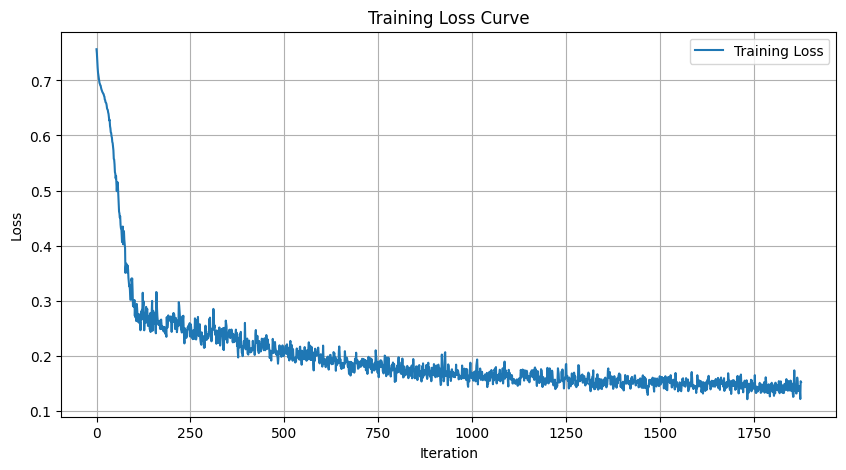

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# Lists to store loss values for plotting
train_losses = []


# Training Loop
for epoch in range(2):
    model.train()
    for i, (inputs, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}")):
        outputs = model(inputs)
        reshaped_outputs = outputs.reshape_as(inputs)

        # ensure target is also between 0 and 1
        # version 1
        # loss = criterion(reshaped_outputs, s(inputs))

        # version 2
        loss = criterion(reshaped_outputs, normalise(inputs))

        loss.backward()
        optimizer.step()

        # zero the gradients for next iteration
        optimizer.zero_grad()

        train_losses.append(loss.item()) # Store loss for plotting
        if (i + 1) % 100 == 0:
            print(f"loss: {loss.item()}")


# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

------------------------------
Visualise reconstruction of images

In [9]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()
test_inputs = []
test_outputs = []
for inputs, _ in test_loader:
    outputs = model(inputs)
    test_inputs.append(inputs.detach().cpu().numpy())
    test_outputs.append(outputs.reshape_as(inputs).detach().cpu().numpy())

In [10]:
# Convert lists of tensors to numpy arrays
test_inputs = np.concatenate(test_inputs)
test_outputs = np.concatenate(test_outputs)

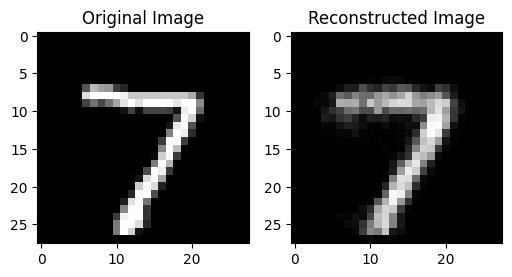

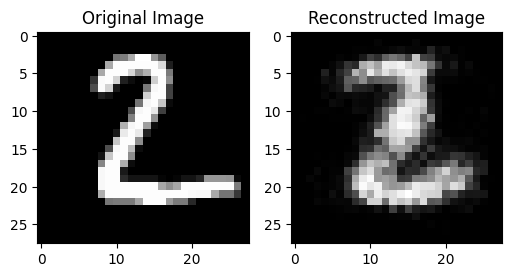

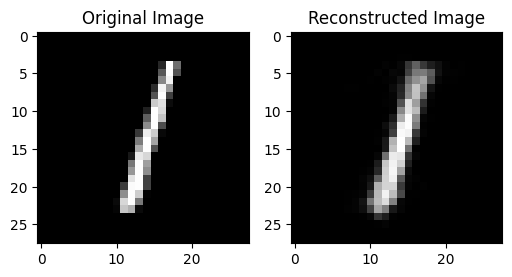

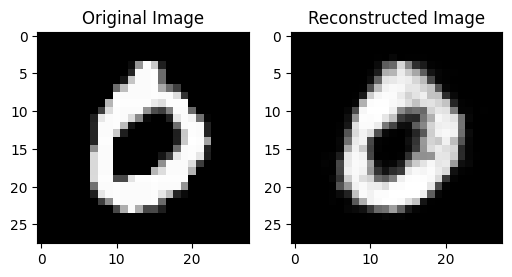

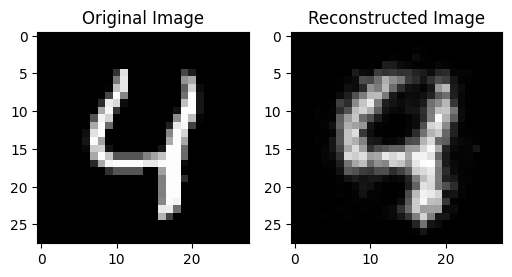

In [11]:
num_images = 5

for i in range(num_images):
    plt.figure(figsize=(6, 3))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(test_inputs[i, :, :], cmap="gray")
    plt.title("Original Image")

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(test_outputs[i, :, :], cmap="gray")
    plt.title("Reconstructed Image")

    plt.show()

# Section 2 - Improve autoencoder

I experimented with various models. The final model is the one that worked best.  

In [12]:
class AdvancedAutoencoder2(nn.Module):
  def __init__(self, latent_dim=32):
    """Make sure encoder compresses the image to a 32-dimensional latent vector."""
    # final val loss: 0.1540
    super(AdvancedAutoencoder2, self).__init__()
    # TODO: Write your implementation here
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 'same', bias = True)
    self.batchnorm2d_1 = nn.BatchNorm2d(num_features = 32)

    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 'same', bias = True)
    self.batchnorm2d_2 = nn.BatchNorm2d(num_features = 64)

    self.flatten = nn.Flatten(start_dim = -3)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size = 2)
    self.dropout = nn.Dropout(p = 0.25)

    self.convBlock = nn.Sequential(
        self.conv1,
        self.relu,
        self.batchnorm2d_1,

        self.pool,
        self.dropout,

        self.conv2,
        self.relu,
        self.batchnorm2d_2,
    )

    self.encoder = nn.Sequential(
        self.flatten,
        nn.Linear(64 * 14 * 14, 128),
        self.relu,
        nn.Linear(128, 64),
        self.relu,
        # nn.BatchNorm1d(num_features = 64, eps = 10**(-5), affine = True, track_running_stats = True),
        nn.Linear(64, 32)
    )
    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        self.relu,
        # nn.BatchNorm1d(num_features = 64, eps = 10**(-5), affine = True, track_running_stats = True),
        nn.Linear(64, 128),
        self.relu,
        nn.Linear(128, 28 * 28),
        nn.Sigmoid()
    )

  def forward(self, x):
    # TODO: Write your implementation here
    x = torch.unsqueeze(x, -3)
    x = self.convBlock(x)
    x = self.encoder(x)
    x = self.decoder(x)
    return x

class AdvancedAutoencoder1(nn.Module):
  def __init__(self, latent_dim=32):
    """Make sure encoder compresses the image to a 32-dimensional latent vector."""
    # final val loss: 0.1494
    super(AdvancedAutoencoder1, self).__init__()
    # TODO: Write your implementation here

    self.relu = nn.ReLU()

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        self.relu,
        nn.Linear(128, 64),
        self.relu,
        nn.Linear(64, 32)
    )
    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        self.relu,
        nn.Linear(64, 128),
        self.relu,
        nn.Linear(128, 28 * 28),
        nn.Sigmoid()
    )

  def forward(self, x):
    # TODO: Write your implementation here
    x = self.encoder(x)
    x = self.decoder(x)
    return x

class AdvancedAutoencoder3(nn.Module):
  def __init__(self, latent_dim=32):
    """Make sure encoder compresses the image to a 32-dimensional latent vector."""
    # final val loss: 0.1330
    super(AdvancedAutoencoder3, self).__init__()
    # TODO: Write your implementation here

    self.relu = nn.ReLU()

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 512),
        self.relu,
        nn.Linear(512, 256),
        self.relu,
        nn.Linear(256, 128),
        self.relu,
        nn.Linear(128, 64),
        self.relu,
        nn.Linear(64, 32)
    )
    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        self.relu,
        nn.Linear(64, 128),
        self.relu,
        nn.Linear(128, 256),
        self.relu,
        nn.Linear(256, 512),
        self.relu,
        nn.Linear(512, 28 * 28),
        nn.Sigmoid()
    )

  def forward(self, x):
    # TODO: Write your implementation here
    x = self.encoder(x)
    x = self.decoder(x)
    return x


class AdvancedAutoencoder4(nn.Module):
  def __init__(self, latent_dim=32):
    """Make sure encoder compresses the image to a 32-dimensional latent vector."""
    # final val loss: 0.2736
    super(AdvancedAutoencoder4, self).__init__()
    # TODO: Write your implementation here

    self.relu = nn.ReLU()
    self.leakyrelu = nn.LeakyReLU()
    self.dropout = nn.Dropout(p = 0.5)

    self.encoder = nn.Sequential(
        nn.Flatten(),

        nn.Linear(28 * 28, 512),
        self.leakyrelu,
        self.dropout,

        nn.Linear(512, 256),
        self.leakyrelu,
        self.dropout,

        nn.Linear(256, 128),
        self.leakyrelu,
        self.dropout,

        nn.Linear(128, 64),
        self.leakyrelu,
        self.dropout,

        nn.Linear(64, 32),
        self.leakyrelu
    )
    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        self.leakyrelu,
        self.dropout,

        nn.Linear(64, 128),
        self.leakyrelu,
        self.dropout,

        nn.Linear(128, 256),
        self.leakyrelu,
        self.dropout,

        nn.Linear(256, 512),
        self.leakyrelu,
        self.dropout,

        nn.Linear(512, 28 * 28),
        nn.Sigmoid()
    )

  def forward(self, x):
    # TODO: Write your implementation here
    x = self.encoder(x)
    x = self.decoder(x)
    return x


class AdvancedAutoencoder5(nn.Module):
  def __init__(self, latent_dim=32):
    """Make sure encoder compresses the image to a 32-dimensional latent vector."""
    # final val loss: 0.7 (doesnt work)
    super(AdvancedAutoencoder5, self).__init__()
    # TODO: Write your implementation here
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 'same', bias = True)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 'same', bias = True)

    self.revconv2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1, bias = True)
    self.revconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = 3, padding = 1, bias = True)

    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size = 2, return_indices = True)
    self.unpool = nn.MaxUnpool2d(kernel_size = 2)
    self.sigmoid = nn.Sigmoid()

    self.flatten1 = nn.Flatten(start_dim = -3)
    self.flatten2 = nn.Flatten(start_dim = 0, end_dim = 1)

    self.unflatten1 = nn.Unflatten(dim = 1, unflattened_size = (1, 28))
    self.unflatten2 = nn.Unflatten(dim = -1, unflattened_size = (32, 7, 7))

    self.convBlock1 = nn.Sequential(
        self.conv1,
        self.relu
    )

    self.convBlock2 = nn.Sequential(
        self.conv2,
        self.relu,
    )


    self.revConvBlock2 = nn.Sequential(
        self.revconv2,
        self.relu,
    )

    self.revConvBlock1 = nn.Sequential(
        self.revconv1,
        self.relu,
    )

    self.encoder = nn.Sequential(
        self.flatten1,
        nn.Linear(32 * 7 * 7, 32),
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 32 * 7 * 7),
    )

  def forward(self, x):
    # TODO: Write your implementation here
    x = self.unflatten1(x)

    x = self.convBlock1(x)
    x, idx1 = self.pool(x)

    x = self.convBlock2(x)
    x, idx2 = self.pool(x)

    x = self.encoder(x)
    x = self.decoder(x)

    # x = x.view((x.shape[0], 32, 7, 7))
    x = self.unflatten2(x)

    x = self.unpool(x, idx2)
    x = self.revConvBlock2(x)

    x = self.unpool(x, idx1)
    x = self.revConvBlock1(x)

    x = self.flatten2(x)

    # x = torch.squeeze(x, -3)
    # x = x.view((x.shape[0], 28 * 28))
    x = self.sigmoid(x)

    return x



class AdvancedAutoencoder6(nn.Module):
  def __init__(self, latent_dim=32):
    """Make sure encoder compresses the image to a 32-dimensional latent vector."""
    # final val loss: 0.1167 (after 5 epochs)
    super(AdvancedAutoencoder6, self).__init__()
    # TODO: Write your implementation here
    self.unflatten1 = nn.Unflatten(dim = 1, unflattened_size = (1, 28))

    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 32)
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 32 * 7 * 7),
        nn.Unflatten(dim = -1, unflattened_size = (32, 7, 7)),
        nn.Upsample(scale_factor = 2),
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        nn.Upsample(scale_factor = 2),
        nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = 3, padding = 1, bias = True),
        # nn.ReLU(),
        nn.Flatten(start_dim = 0, end_dim = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # TODO: Write your implementation here
    x = self.unflatten1(x)
    x = self.encoder(x)
    x = self.decoder(x)

    return x


class AdvancedAutoencoder(nn.Module):
  def __init__(self, latent_dim=32):
    """Make sure encoder compresses the image to a 32-dimensional latent vector."""
    # final val loss: 0.1178 (after 2 epochs)
    # final val loss: 0.1044 (after 5 epochs)
    super(AdvancedAutoencoder, self).__init__()
    # TODO: Write your implementation here

    self.encoder = nn.Sequential(
        nn.Unflatten(dim = 1, unflattened_size = (1, 28)),
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1, bias = True),
        nn.MaxPool2d(kernel_size = 2),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1, bias = True),
        nn.MaxPool2d(kernel_size = 2),
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 32 * 7 * 7),
        nn.Unflatten(dim = -1, unflattened_size = (32, 7, 7)),
        nn.Upsample(scale_factor = 2),
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1, bias = True),
        nn.Upsample(scale_factor = 2),
        nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = 3, padding = 1, bias = True),
        nn.Flatten(start_dim = 0, end_dim = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # TODO: Write your implementation here
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [13]:
for name, param in model.named_parameters():
    print(name, param.shape)

encoder.1.weight torch.Size([128, 784])
encoder.1.bias torch.Size([128])
encoder.3.weight torch.Size([64, 128])
encoder.3.bias torch.Size([64])
encoder.5.weight torch.Size([32, 64])
encoder.5.bias torch.Size([32])
decoder.0.weight torch.Size([64, 32])
decoder.0.bias torch.Size([64])
decoder.2.weight torch.Size([128, 64])
decoder.2.bias torch.Size([128])
decoder.4.weight torch.Size([784, 128])
decoder.4.bias torch.Size([784])


--------------------
Cap model forward pass speed to ensure quick training/evaluation

In [14]:
model = AdvancedAutoencoder()
model.eval()
max_allowed_time = 0.05  # seconds

# Measure time for the forward pass
i, (inputs, _) = next(enumerate(train_loader))
start_time = time.time()
output = model(inputs)
end_time = time.time()

# Measure once again, time for the forward pass
i, (inputs, _) = next(enumerate(train_loader))
start_time = time.time()
output = model(inputs)
end_time = time.time()

elapsed_time = end_time - start_time

# Assert the time constraint
assert elapsed_time <= max_allowed_time, f"Forward pass exceeded time limit! Took {elapsed_time:.8f} seconds"
print(f"Forward pass took {elapsed_time:.8f} seconds")

Forward pass took 0.04881692 seconds


--------------------
Random split dataset into training and validation

In [15]:
def random_split(dataset, lengths):
    print("intended length of training set:", lengths[0])
    print("intended length of val set:", lengths[1])

    perm = np.random.permutation(range(len(dataset)))
    trainset = []
    valset = []

    for i in range(len(dataset)):
        if i < lengths[0]:
            trainset.append(dataset[i])
        else:
            valset.append(dataset[i])



    print("\nlength of sampled training set:", len(trainset))
    print("length of sampled validation set:", len(valset))
    print(trainset[0][0].shape, valset[0][0].shape)

    return trainset, valset
    raise NotImplementedError()

In [16]:
# Calculate split sizes
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

intended length of training set: 48000
intended length of val set: 12000

length of sampled training set: 48000
length of sampled validation set: 12000
torch.Size([28, 28]) torch.Size([28, 28])


---------------
Model training

In [17]:
# train model and calculate validation loss (val_loss)

def train_loop(model, loader, epoch, criterion, optimizer):
    model.train()
    for i, (inputs, _) in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}")):
        outputs = model(inputs)
        reshaped_outputs = outputs.reshape_as(inputs)

        # ensure target is also between 0 and 1
        # version 1
        # loss = criterion(outputs, s(inputs))

        # version 2
        # loss = criterion(reshaped_outputs, normalise(inputs))
        loss = criterion(outputs, normalise(inputs))

        loss.backward()
        optimizer.step()

        # zero the gradients for next iteration
        optimizer.zero_grad()

        # train_losses.append(loss.item()) # Store loss for plotting
        if (i + 1) % 100 == 0:
            print(f"TRAIN loss: {loss.item()}")

def val_loop(model, loader, epoch, criterion):
    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}")):
            outputs = model(inputs)
            reshaped_outputs = outputs.reshape_as(inputs)

            # ensure target is also between 0 and 1
            # version 1
            # loss = criterion(reshaped_outputs, s(inputs))

            # version 2
            loss = criterion(reshaped_outputs, normalise(inputs))
            # loss = criterion(outputs, normalise(inputs))

            # val_losses.append(loss.item()) # Store loss for plotting
            if (i + 1) % 50 == 0:
                print(f"VAL loss: {loss.item()}")

    print(f"\nEpoch {epoch + 1} final val loss:", loss, "\n")


In [18]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
for epoch in range(5):
    train_loop(model,train_loader, epoch, criterion, optimizer)
    val_loop(model, val_loader, epoch, criterion)


Epoch 1:  13%|█▎        | 101/750 [00:11<01:08,  9.49it/s]

TRAIN loss: 0.24325039982795715


Epoch 1:  27%|██▋       | 201/750 [00:22<00:56,  9.67it/s]

TRAIN loss: 0.20902785658836365


Epoch 1:  40%|████      | 301/750 [00:34<00:45,  9.89it/s]

TRAIN loss: 0.17584367096424103


Epoch 1:  53%|█████▎    | 400/750 [00:45<00:35,  9.91it/s]

TRAIN loss: 0.150008425116539


Epoch 1:  67%|██████▋   | 501/750 [00:57<00:26,  9.50it/s]

TRAIN loss: 0.14969056844711304


Epoch 1:  80%|████████  | 601/750 [01:08<00:22,  6.53it/s]

TRAIN loss: 0.1306247115135193


Epoch 1:  93%|█████████▎| 701/750 [01:20<00:07,  6.82it/s]

TRAIN loss: 0.13476233184337616


Epoch 1:  29%|██▊       | 54/188 [00:01<00:04, 27.10it/s]

VAL loss: 0.1318822056055069


Epoch 1:  56%|█████▌    | 105/188 [00:03<00:03, 27.63it/s]

VAL loss: 0.12772679328918457


Epoch 1:  81%|████████▏ | 153/188 [00:05<00:01, 27.46it/s]

VAL loss: 0.13921529054641724


Epoch 1: 100%|██████████| 188/188 [00:07<00:00, 25.90it/s]



Epoch 1 final val loss: tensor(0.1395) 



Epoch 2:  13%|█▎        | 101/750 [00:12<01:39,  6.52it/s]

TRAIN loss: 0.13409079611301422


Epoch 2:  27%|██▋       | 201/750 [00:24<01:03,  8.67it/s]

TRAIN loss: 0.11858775466680527


Epoch 2:  40%|████      | 301/750 [00:37<00:51,  8.80it/s]

TRAIN loss: 0.11666513234376907


Epoch 2:  53%|█████▎    | 401/750 [00:49<00:41,  8.38it/s]

TRAIN loss: 0.12089942395687103


Epoch 2:  67%|██████▋   | 501/750 [01:02<00:28,  8.75it/s]

TRAIN loss: 0.11738786846399307


Epoch 2:  80%|████████  | 601/750 [01:15<00:17,  8.45it/s]

TRAIN loss: 0.12098602205514908


Epoch 2:  93%|█████████▎| 701/750 [01:27<00:05,  8.73it/s]

TRAIN loss: 0.10625199228525162


Epoch 2:  29%|██▊       | 54/188 [00:01<00:04, 28.10it/s]

VAL loss: 0.11109835654497147


Epoch 2:  56%|█████▌    | 105/188 [00:03<00:03, 27.43it/s]

VAL loss: 0.11051540076732635


Epoch 2:  81%|████████▏ | 153/188 [00:05<00:01, 27.75it/s]

VAL loss: 0.11910385638475418


Epoch 2: 100%|██████████| 188/188 [00:06<00:00, 27.51it/s]



Epoch 2 final val loss: tensor(0.1202) 



Epoch 3:  13%|█▎        | 101/750 [00:12<01:15,  8.64it/s]

TRAIN loss: 0.11241140216588974


Epoch 3:  27%|██▋       | 201/750 [00:25<01:05,  8.39it/s]

TRAIN loss: 0.11402878165245056


Epoch 3:  40%|████      | 301/750 [00:38<00:51,  8.68it/s]

TRAIN loss: 0.10714247077703476


Epoch 3:  53%|█████▎    | 401/750 [00:50<00:41,  8.43it/s]

TRAIN loss: 0.11569926887750626


Epoch 3:  67%|██████▋   | 501/750 [01:03<00:28,  8.71it/s]

TRAIN loss: 0.1136835366487503


Epoch 3:  80%|████████  | 601/750 [01:16<00:17,  8.53it/s]

TRAIN loss: 0.10673655569553375


Epoch 3:  93%|█████████▎| 701/750 [01:28<00:05,  8.37it/s]

TRAIN loss: 0.1059374287724495


Epoch 3:  29%|██▉       | 55/188 [00:02<00:04, 27.62it/s]

VAL loss: 0.10191144794225693


Epoch 3:  55%|█████▍    | 103/188 [00:04<00:03, 27.47it/s]

VAL loss: 0.1038087010383606


Epoch 3:  82%|████████▏ | 154/188 [00:06<00:01, 26.54it/s]

VAL loss: 0.11188250035047531


Epoch 3: 100%|██████████| 188/188 [00:07<00:00, 25.86it/s]



Epoch 3 final val loss: tensor(0.1116) 



Epoch 4:  13%|█▎        | 101/750 [00:12<01:15,  8.59it/s]

TRAIN loss: 0.10441682487726212


Epoch 4:  27%|██▋       | 201/750 [00:25<01:04,  8.49it/s]

TRAIN loss: 0.10605043172836304


Epoch 4:  40%|████      | 301/750 [00:38<00:51,  8.78it/s]

TRAIN loss: 0.10775551199913025


Epoch 4:  53%|█████▎    | 401/750 [00:50<00:42,  8.29it/s]

TRAIN loss: 0.11001759022474289


Epoch 4:  67%|██████▋   | 501/750 [01:03<00:29,  8.48it/s]

TRAIN loss: 0.09457874298095703


Epoch 4:  80%|████████  | 601/750 [01:16<00:16,  8.80it/s]

TRAIN loss: 0.09859047085046768


Epoch 4:  93%|█████████▎| 701/750 [01:28<00:05,  8.64it/s]

TRAIN loss: 0.0960116758942604


Epoch 4:  28%|██▊       | 52/188 [00:02<00:07, 18.52it/s]

VAL loss: 0.09645981341600418


Epoch 4:  56%|█████▌    | 105/188 [00:04<00:03, 27.49it/s]

VAL loss: 0.09832660853862762


Epoch 4:  81%|████████▏ | 153/188 [00:06<00:01, 28.15it/s]

VAL loss: 0.10595128685235977


Epoch 4: 100%|██████████| 188/188 [00:07<00:00, 23.75it/s]



Epoch 4 final val loss: tensor(0.1061) 



Epoch 5:  13%|█▎        | 101/750 [00:12<01:16,  8.44it/s]

TRAIN loss: 0.09261076897382736


Epoch 5:  27%|██▋       | 201/750 [00:25<01:05,  8.39it/s]

TRAIN loss: 0.10015150904655457


Epoch 5:  40%|████      | 301/750 [00:38<00:53,  8.42it/s]

TRAIN loss: 0.10450389236211777


Epoch 5:  53%|█████▎    | 401/750 [00:50<00:41,  8.50it/s]

TRAIN loss: 0.10196834802627563


Epoch 5:  67%|██████▋   | 501/750 [01:03<00:29,  8.53it/s]

TRAIN loss: 0.09436655789613724


Epoch 5:  80%|████████  | 601/750 [01:16<00:17,  8.29it/s]

TRAIN loss: 0.1000571921467781


Epoch 5:  93%|█████████▎| 701/750 [01:28<00:05,  8.45it/s]

TRAIN loss: 0.10110446065664291


Epoch 5:  29%|██▊       | 54/188 [00:01<00:04, 27.76it/s]

VAL loss: 0.09411029517650604


Epoch 5:  55%|█████▍    | 103/188 [00:04<00:04, 18.05it/s]

VAL loss: 0.0953880101442337


Epoch 5:  81%|████████▏ | 153/188 [00:06<00:01, 27.48it/s]

VAL loss: 0.10243472456932068


Epoch 5: 100%|██████████| 188/188 [00:07<00:00, 23.66it/s]


Epoch 5 final val loss: tensor(0.1034) 



In [19]:
torch.save(model, "/content/convolutional_autoencoder_model.pth")

# Section 3 - Generate new RBG Images

--------------------
Load best autoencoder

In [20]:
def load_model():
  model = torch.load("/content/convolutional_autoencoder_model.pth")
  model.eval()
  return model

model = load_model()

for name, param in model.named_parameters():
    print(name, param.shape)

encoder.1.weight torch.Size([16, 1, 3, 3])
encoder.1.bias torch.Size([16])
encoder.3.weight torch.Size([32, 16, 3, 3])
encoder.3.bias torch.Size([32])
encoder.6.weight torch.Size([512, 1568])
encoder.6.bias torch.Size([512])
encoder.8.weight torch.Size([256, 512])
encoder.8.bias torch.Size([256])
encoder.10.weight torch.Size([128, 256])
encoder.10.bias torch.Size([128])
encoder.12.weight torch.Size([64, 128])
encoder.12.bias torch.Size([64])
encoder.14.weight torch.Size([32, 64])
encoder.14.bias torch.Size([32])
decoder.0.weight torch.Size([64, 32])
decoder.0.bias torch.Size([64])
decoder.2.weight torch.Size([128, 64])
decoder.2.bias torch.Size([128])
decoder.4.weight torch.Size([256, 128])
decoder.4.bias torch.Size([256])
decoder.6.weight torch.Size([512, 256])
decoder.6.bias torch.Size([512])
decoder.8.weight torch.Size([1568, 512])
decoder.8.bias torch.Size([1568])
decoder.11.weight torch.Size([32, 16, 3, 3])
decoder.11.bias torch.Size([16])
decoder.13.weight torch.Size([16, 1, 3, 3

<ipython-input-20-8e82bc15fe3b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/convolutional_autoencoder_model.pth")


------------------------
Determine the mean and standard deviation for the latent vectors for each digit

In [21]:
def statistic(model, stats, dataset):
    i = 0
    model.eval()
    with torch.no_grad():
        for input,label in dataset:
            input = torch.unsqueeze(input, 0)
            # input = nn.Unflatten(dim = 1, unflattened_size = (1, 28))(input)
            dlatent = model.encoder(input)
            stats[label].append(dlatent)
            i += 1

    for i in stats:
        all = torch.stack(stats[i], dim = 0)
        mean = torch.mean(all, dim = 0)
        std = torch.std(all, dim = 0)
        stats[i] = {"mean": mean, 'std': std}

stats = {i:[] for i in range(10)}
statistic(model, stats, train_dataset)


-----------------
Generate RGB digit

In [22]:
def generate_image_from_digit(digit: int, n_samples: int, color = "all") -> NDArray[np.float32]:
    """
    Returns an RGB MNIST image (with values between [0, 255]) as a 3D NumPy array of dtype float32.
    """
    assert digit <= 9  and digit >= 0, "Digit must be between 0 and 9"
    # TODO: Write your implementation here
    generated_images = []

    factor = 0.5
    mean = stats[digit]["mean"]
    std = stats[digit]["std"] * factor

    dlatent_r = torch.normal(mean, std)
    dlatent_g = torch.normal(mean, std)
    dlatent_b = torch.normal(mean, std)

    model.eval()
    with torch.no_grad():
        for i in range(n_samples):
            if color == "all":
                r = model.decoder(dlatent_r)
                g = model.decoder(dlatent_g)
                b = model.decoder(dlatent_b)

            elif color == 'red':
                r = model.decoder(dlatent_r)
                g = torch.zeros((1, 28, 28))
                b = torch.zeros((1, 28, 28))

            elif color == 'blue':
                b = model.decoder(dlatent_b)
                g = torch.zeros((1, 28, 28))
                r = torch.zeros((1, 28, 28))

            else:
                g = model.decoder(dlatent_g)
                b = torch.zeros((1, 28, 28))
                r = torch.zeros((1, 28, 28))

            r = torch.squeeze(r, dim = 0)
            g = torch.squeeze(g, dim = 0)
            b = torch.squeeze(b, dim = 0)

            img = torch.stack((r,g,b), dim = -1)
            numpy_img = img.numpy()

            generated_images.append(numpy_img)

    return generated_images


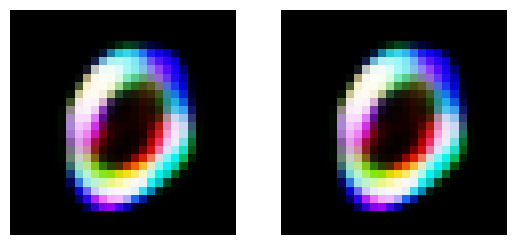

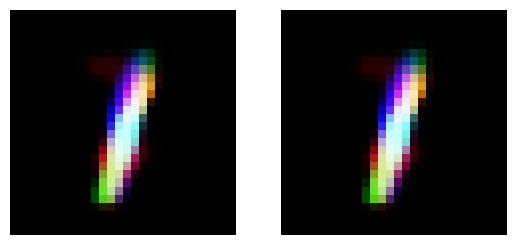

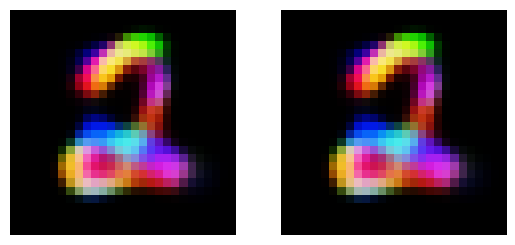

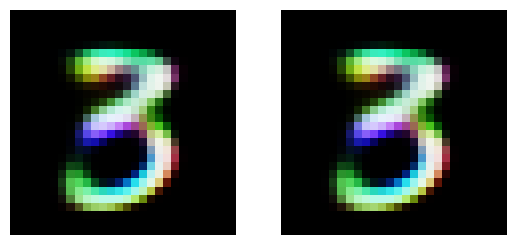

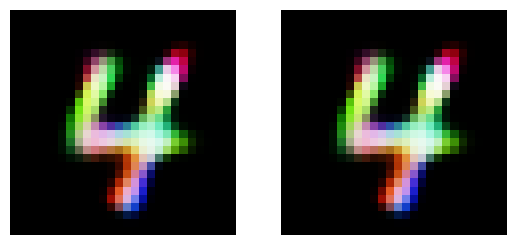

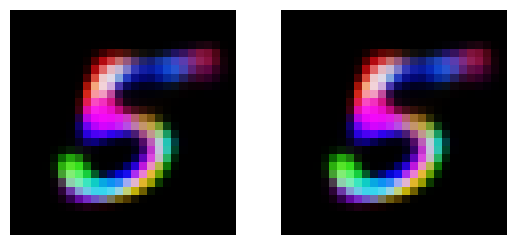

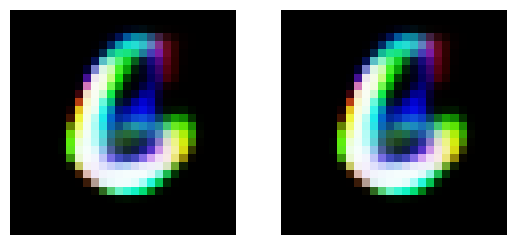

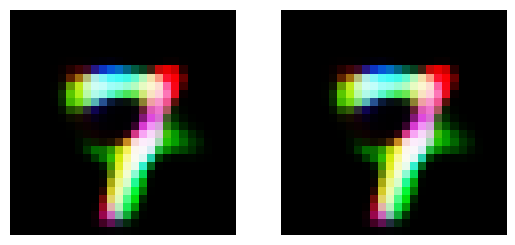

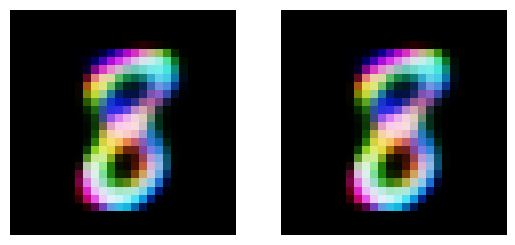

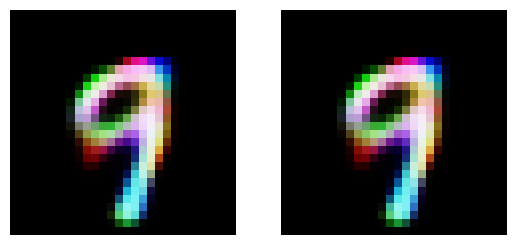

In [23]:
def visualise_images(digit, n_samples):
  generated_images = generate_image_from_digit(digit, n_samples, "all")
  for i in range(n_samples):
      plt.subplot(1, n_samples, i + 1)
      plt.imshow(generated_images[i], cmap='gray')
      plt.axis('off')

  plt.show()

for digit in range(10):
  visualise_images(digit, 2)

In [24]:
def check_generator_produces_different_images(digit):
    generated_images = [generate_image_from_digit(digit, 1)[0] for _ in range(2)]
    return not torch.allclose(torch.from_numpy(generated_images[0]), torch.from_numpy(generated_images[1]))

In [25]:
for digit in range(10):
  assert check_generator_produces_different_images(digit), "Generator must be able to produce different images for the same digit"